# MDM imaging analysis

In [1]:
# load modules
from scipy.stats import stats
import scipy.io as spio# import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt
import os
import glob
# from sklearn import preprocessing
# from sklearn.preprocessing import StandardScaler
# from nilearn.input_data import NiftiMasker
# import nilearn.plotting as plotting
# from nilearn.image import mean_img
import pickle
import pandas as pd
import seaborn as sns 

%matplotlib inline 
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})

Autosaving every 5 seconds


In [2]:
base_root = '/home/rj299/project/mdm_analysis/'
data_root = '/home/rj299/project/mdm_analysis/data_rename'
out_root = '/home/rj299/project/mdm_analysis/output'

# data_root = 'D:\Ruonan\Projects in the lab\MDM Project\Medical Decision Making Imaging\MDM_imaging\Imaging Analysis\data_rename'
# out_root = 'D:\Ruonan\Projects in the lab\MDM Project\Medical Decision Making Imaging\MDM_imaging\Imaging Analysis\output'

In [3]:
# get all subjects folder
sub_fold = glob.glob(data_root + '/sub-*')
# sub_fold = glob.glob(data_root + '\\sub-*')

# get all subject id
# sub_num = [] 
# for fold in sub_fold:
#     sub_id = fold.split('sub-')[1]
#     sub_num.append(int(sub_id))


# Subjects included in analysis
sub_num = [2073, 2550, 2582, 2583, 2584, 2585, 2588, 2592, 2593, 2594, 2596, 2597, 2598, 
           2600, 2624, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2662, 2663, 2664, 2665, 2666]

sub_num.sort()
print('All subjects included in analysis:', sub_num)

All subjects included in analysis: [2073, 2550, 2582, 2583, 2584, 2585, 2588, 2592, 2593, 2594, 2596, 2597, 2598, 2600, 2624, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2662, 2663, 2664, 2665, 2666]


## Rename task number to run number.

In [6]:
# functions for changing file names

# rename all files by adding run number determined by session and task number during scanning
def addRunNum(directory): 
    """ Add scan run numbers to file name
    
    Parameters
    --------------
    directory: directory for a subject, contains data for all runs
    
    """
    
    os.chdir(directory)
    
    # get sorted task number from the directory
    task_num_all = getTaskNum(directory)
    
    # add run number and rename
    for filename in os.listdir(directory):
        # get task number
        task_num = int(filename.split('_task-task')[1].split('_')[0])
        
        # get the run number based on all the task number in the directory
        run_count = task_num_all.index(task_num) + 1

        
        filename_new = filename.split('_task-task%s' %task_num)[0] + '_task-%s' %run_count + filename.split('_task-task%s' %task_num)[1]

        os.rename(filename, filename_new)  
        print(filename_new)

# get all task numbers for ses one
def getTaskNum(directory):
    """ Get all the task number for a session
     
    Parameters
    -----------------
    directory: data directory for a subject
    
    Return
    -----------------
    task_num: sorted task number for each session
    """
    file_ses = glob.glob('sub-*_ses-1_task*_bold.nii.gz')
    
    task_num = []
    
    for file in file_ses:
        task_id = file.split('_task-task')[1].split('_space')[0]
        task_num.append(int(task_id))
    
    task_num.sort()
    
    return task_num

The following two sections change the file names and only need running ONCE.

In [8]:
# rename files and add run number in the file name
# needs running only ONCE

# for fold in sub_fold:
#     if fold != '/home/rj299/project/mdm_analysis/data_rename/sub-2582':
#         fold_func = os.path.join(fold, 'ses-1', 'func')
#         addRunNum(fold_func)

In [10]:
# rename files and add run number in the file name
# subject 2582 only, because the files are named in a different way
# rename all files by adding run number determined by session and task number during scanning

# run ONLY ONCE

# def addRunNum_2582(directory): 
#     """ Add scan run numbers to file name
    
#     Parameters
#     --------------
#     directory: directory for a subject, contains data for all runs
    
#     """
#     os.chdir(directory)
    
#     # get sorted task number from the directory
#     task_num_all = getTaskNum_2582(directory)
    
#     # add run number and rename
#     for filename in os.listdir(directory):
#         # get task number
#         task_num = int(filename.split('_task-')[1].split('_')[0])
        
#         # get the run number based on all the task number in the directory
#         run_count = task_num_all.index(task_num) + 1

        
#         filename_new = filename.split('_task-%s' %task_num)[0] + '_task-%s' %run_count + filename.split('_task-%s' %task_num)[1]

#         os.rename(filename, filename_new)  
#         print(filename_new)

# # get all task numbers for ses one
# def getTaskNum_2582(directory):
#     """ Get all the task number for a session
    
#     Parameters
#     -----------------
#     directory: data directory for a subject
    
#     Return
#     -----------------
#     task_num: sorted task number for each session
#     """
#     file_ses = glob.glob('sub-*_ses-1_task*_bold.nii.gz')
    
#     task_num = []
    
#     for file in file_ses:
#         task_id = file.split('_task-')[1].split('_space')[0]
#         task_num.append(int(task_id))
    
#     task_num.sort()
    
#     return task_num

# addRunNum_2582(os.path.join(data_root, 'sub-2582','ses-1','func'))

## Load anatomical data

In [45]:
def load_anat(sub):
    """ Load single subject anatomical data
    
    Parameters:
    ----------
    sub: subject id
    
    Retrun:
    ----------
    
    """
    
    anat_in = os.path.join(data_root, 'sub-%s' %sub, 'anat', 'sub-%s_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz' %sub)
    anat = nib.load(anat_in)
    
    return anat

In [49]:
# load all subjects' anatomical data
anat = []
for sub in sub_num:
    anat.append(load_anat(sub))

# average
anat_mean = mean_img(anat)

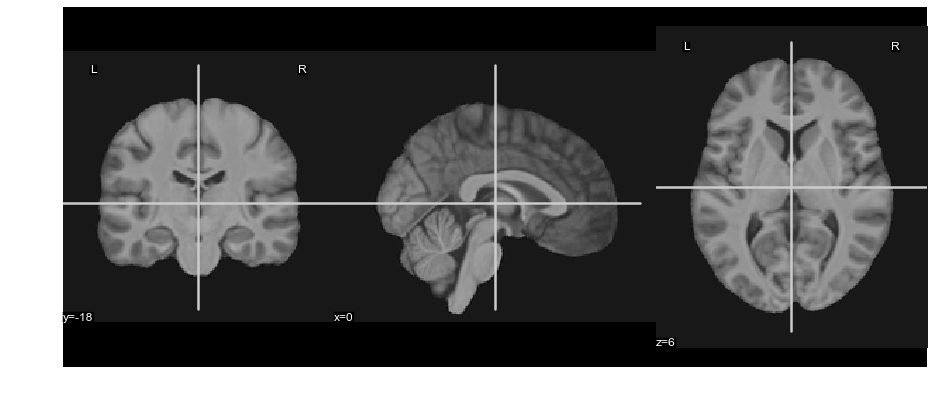

In [50]:
fig = plt.figure(figsize = (12,5))
plotting.plot_anat(anat_mean, black_bg = True, figure = fig)

3


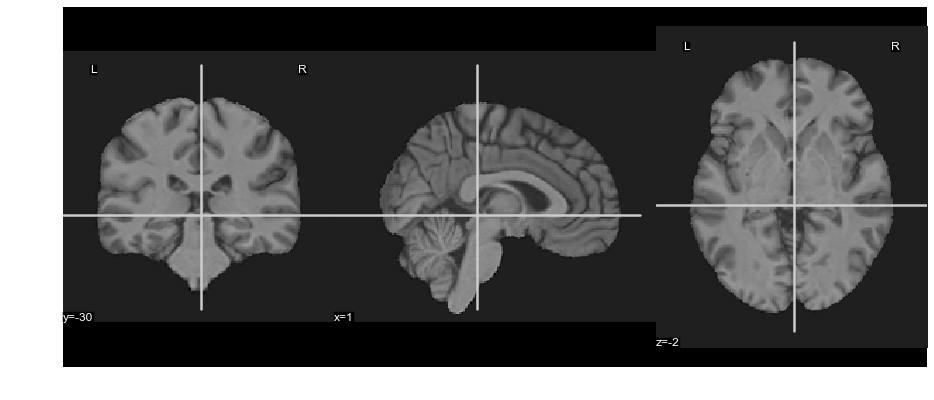

In [51]:
print(len(anat))

# single subject anatomical plot
fig = plt.figure(figsize = (12,5))
plotting.plot_anat(anat[0], black_bg = True, figure = fig)

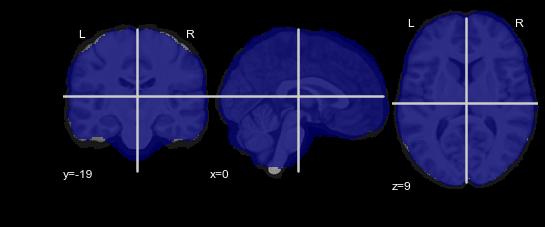

In [54]:
mask_whb = load_whb_mask(2073,2)
plotting.plot_roi(mask_whb, bg_img = anat_mean)

## Create design matrix from behavioral log

In [12]:
data_behav_root = '/home/rj299/project/mdm_analysis/data_behav'
# data_behav_root = 'D:\Ruonan\Projects in the lab\MDM Project\Medical Decision Making Imaging\MDM_imaging\Behavioral Analysis\PTB Behavior Log'

In [3]:
# subjects for imaging analysis
# sub_num = [2073, 2550, 2582, 2583, 2584, 2585, 2588, 2592, 2593, 2594, 2596, 2597, 2598, 2600, 2624, 2650, 2651, 2652, 2653, 2655, 2656, 2657, 2659, 2660, 2662, 2663, 2664, 2665, 2666]

In [13]:
def _todict(matobj):
    '''
    Author: Or
    
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

def _check_keys(dict):
    '''
    Author: Or
    
    checks if entries in dictionary are mat-objects. If yes todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict 

def loadmat(filename):
    '''
    Author: Or
    
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    
    from: `StackOverflow <http://stackoverflow.com/questions/7008608/scipy-io-loadmat-nested-structures-i-e-dictionaries>`_
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [10]:
sub_id = 2073
mat_med_name = os.path.join(data_behav_root, 'subj%s' %sub_id, 'MDM_MED_%s.mat' %sub_id)

In [11]:
mat_med_name

'/home/rj299/project/mdm_analysis/data_behav/subj2073/MDM_MED_2073.mat'

In [12]:
behav_med = loadmat(mat_med_name)

In [13]:
list(behav_med.keys())[3]

'Datamed'

In [10]:
behav_med['Datamed'].keys()

dict_keys(['observer', 'date', 'refSide', 'filename', 'stimulus', 'colorKey', 'numTrials', 'block', 'vals', 'probs', 'ambigs', 'colors', 'ITIs', 'trialTime', 'choice', 'rt', 'Summary'])

In [11]:
choice = behav_med['Datamed']['choice']
print(choice)
print(choice.shape)

[2 1 1 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 2 1 2 2 1 2 2 2 2 1 1 2 2 1 2 1 2 2 2
 2 1 1 1 2 2 1 1 1 2 2 1 2 1 2 1 1 1 2 2 1 2 2 2 1 1 2 2 2 1 1 2 1 2 2 2 2
 2 2 1 2 1 2 2 2 2 2]
(84,)


In [12]:
behav_med['Datamed']['trialTime'][0]._fieldnames

['trialStartTime',
 'respStartTime',
 'feedbackStartTime',
 'ITIStartTime',
 'trialEndTime']

In [13]:
behav_med['Datamed']['trialTime'][0].__dict__['trialStartTime']

array([2016.   ,   11.   ,    7.   ,   13.   ,   11.   ,   29.497])

In [14]:
vars(behav_med['Datamed']['trialTime'][0])

{'ITIStartTime': array([2016.   ,   11.   ,    7.   ,   13.   ,   11.   ,   36.552]),
 '_fieldnames': ['trialStartTime',
  'respStartTime',
  'feedbackStartTime',
  'ITIStartTime',
  'trialEndTime'],
 'feedbackStartTime': array([2016.   ,   11.   ,    7.   ,   13.   ,   11.   ,   36.036]),
 'respStartTime': array([2016.   ,   11.   ,    7.   ,   13.   ,   11.   ,   35.502]),
 'trialEndTime': array([2016.   ,   11.   ,    7.   ,   13.   ,   11.   ,   44.497]),
 'trialStartTime': array([2016.   ,   11.   ,    7.   ,   13.   ,   11.   ,   29.497])}

In [81]:
list(range(0, 21))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [14]:
def readConditions(matFile, x): # takes name of file and when to begin (i.e. first block is zero. second is 21 etc.)
    """ read condition onset and duration
    Author: Or
    
    Parameters
    -------------
    matFile: filename
    x: trial index at the begining of each block
    
    Return
    -------------
    events
    """
    
    metaData = loadmat(matFile)    
    # get the key names for the data, as half is 'Datamed', half is 'Datamon'
    data_keyname = list(metaData.keys())[3]    
    # trial number per block
    trial_num = 21 
    
    timeStamp = []
    condition = []
    events = []
    resultsArray = []
    duration = []
   
    ambigs = metaData[data_keyname]['ambigs']
    probs = metaData[data_keyname]['probs']
    vals = metaData[data_keyname]['vals']
    choice = metaData[data_keyname]['choice']
    refside = metaData[data_keyname]['refSide']
    
    # calculate response from choice and refside
    resp = np.ones(choice.shape) # 1-choose lottery
    resp[choice == refside] = 0 # 0-choose reference
    resp[choice == 0] = np.nan # nan-no respone
    
    # x= 0 # where to start
    for i in range(x, x+trial_num):
        #a= metaData['Data']['trialTime'][i]
        #b = vars(a)
      
        resultsArray = vars(metaData[data_keyname]['trialTime'][i])['trialStartTime'] - vars(metaData[data_keyname]['trialTime'][x])['trialStartTime']
        timeStamp.append(int(round((3600*resultsArray[3] + 60*resultsArray[4] + resultsArray[5] -9)))) # using int and round to round to the close integer. 
        duration.append(6)
       
        if ambigs[i] == 0:
            condition.append('risk')
        else:
            condition.append('amb')
    
    events= pd.DataFrame({'trial_type':condition, 'onset':timeStamp, 'duration':duration, 'probs': probs[range(x, x+trial_num)], 'ambigs': ambigs[range(x, x+trial_num)], 'vals': vals[range(x, x+trial_num)], 'resp': resp[range(x, x+trial_num)]})[1:] # building data frame from what we took. Removing first row because its not used. 
    return events



def organizeBlocks(subNum):
    # Read both mat files (first timestamp)
    # check first block of each day. 
    # check thrird of each day
    # sort
    trial_num = 21
    
    orderArray = []
    
    mat_med_name = os.path.join(data_behav_root, 'subj%s' %subNum, 'MDM_MED_%s.mat' %subNum)    
    mat_mon_name = os.path.join(data_behav_root, 'subj%s' %subNum, 'MDM_MON_%s.mat' %subNum)    
    
#     matFileLoss = '/media/Drobo/Levy_Lab/Projects/R_A_PTSD_Imaging/Data/Behavior data/Behavior_fitpar/Behavior data fitpar_091318/RA_LOSS_%s_fitpar.mat'%subNum
#     matFileGain = '/media/Drobo/Levy_Lab/Projects/R_A_PTSD_Imaging/Data/Behavior data/Behavior_fitpar/Behavior data fitpar_091318/RA_GAINS_%s_fitpar.mat'%subNum
    metaDataMed = loadmat(mat_med_name)
    data_med_keyname = list(metaDataMed.keys())[3]
    metaDataMon = loadmat(mat_mon_name)
    data_mon_keyname = list(metaDataMon.keys())[3]
    
    # trial start time of the 1st and the 3rd block in each domain
    a= {'1stMed':list(vars(metaDataMed[data_med_keyname]['trialTime'][0])['trialStartTime']), '3rdMed':list(vars(metaDataMed[data_med_keyname]['trialTime'][trial_num*2])['trialStartTime']), '1stMon':list(vars(metaDataMon[data_mon_keyname]['trialTime'][0])['trialStartTime']), '3rdMon':list(vars(metaDataMon[data_mon_keyname]['trialTime'][trial_num*2])['trialStartTime'])}
    # sort by trial start time
    s = [(k, a[k]) for k in sorted(a, key=a.get, reverse=False)]
    for k, v in s:
        print (k, v)
        orderArray.append(k)
    
    totalEvent = []
    for n in orderArray:
        print (n)
        if n=='1stMed':
            # run Med mat file on readConcitions function on first two blocks (i.e. 0, 21)
            print (n)
            for x in [0,trial_num]:
                event = readConditions(mat_med_name, x)
                event['condition'] = 'Med'
                totalEvent.append(event)
        elif n=='1stMon':
            # run Mon mat file on readCondition function
            print (n)
            for x in [0,trial_num]:
                event = readConditions(mat_mon_name, x)
                event['condition'] = 'Mon'
                totalEvent.append(event)
        elif n=='3rdMed':
            print (n)
            for x in [trial_num*2, trial_num*3]:
                event = readConditions(mat_med_name, x)
                event['condition'] = 'Med'
                totalEvent.append(event)
        elif n=='3rdMon':
            # run Mon from 3rd block
            print (n)
            for x in [trial_num*2, trial_num*3]:
                event = readConditions(mat_mon_name, x)
                event['condition'] = 'Mon'
                totalEvent.append(event)
        else:
            print ('The condition ' + n + ' is not clear.')
        
        # the end result is an array of data sets per each run (i.e. block) - called totalEvent
    return totalEvent

In [15]:
totalEvent_sub = organizeBlocks(2073)

1stMon [2016.0, 11.0, 7.0, 12.0, 57.0, 59.815999999998894]
1stMed [2016.0, 11.0, 7.0, 13.0, 11.0, 29.497000000003027]
3rdMon [2016.0, 11.0, 7.0, 13.0, 24.0, 6.7309999999997672]
3rdMed [2016.0, 11.0, 7.0, 13.0, 37.0, 32.076000000000931]
1stMon
1stMon
1stMed
1stMed
3rdMon
3rdMon
3rdMed
3rdMed


In [17]:
totalEvent_sub[0]

,ambigs,duration,onset,probs,resp,trial_type,vals,condition
1,0.00,6,6,0.25,0.0,risk,5,Mon
2,0.74,6,20,0.50,0.0,amb,8,Mon
3,0.00,6,35,0.75,1.0,risk,12,Mon
4,0.00,6,50,0.75,1.0,risk,25,Mon
5,0.00,6,65,0.50,0.0,risk,8,Mon
6,0.00,6,81,0.50,1.0,risk,25,Mon
7,0.24,6,97,0.50,0.0,amb,25,Mon
8,0.00,6,113,0.25,0.0,risk,12,Mon
9,0.24,6,128,0.50,0.0,amb,12,Mon
10,0.00,6,143,0.25,0.0,risk,25,Mon


In [20]:
# read conditions and write into csv files

# for sub_id in sub_num:
#     totalEvent_sub = organizeBlocks(sub_id)
#     # write into csv
    
#     for task_id in range(8):
#         pd.DataFrame(totalEvent_sub[task_id]).to_csv(os.path.join(out_root, 'event_files', 'sub-' + str(sub_id)+ '_task-' +str(task_id+1) + '_cond.csv'), 
#                           index = False, sep = '\t')

## Functional data and GLM
Ref: https://cogmaster-stats.github.io/python-cogstats/auto_examples/plot_auditory_analysis.html

Using nypipe: https://nipype.readthedocs.io/en/latest/users/examples/fmri_nipy_glm.html

Use Or's code

In [4]:
subject_id = 2583

events_file = os.path.join(out_root,'sub-%s_task-3_cond.csv' %subject_id)

In [43]:
events = pd.read_csv(events_file, sep=r'\s+')

In [44]:
events.shape

(20, 8)

In [45]:
events

,ambigs,duration,onset,probs,resp,trial_type,vals,condition
0,0.50,6,6,0.50,1.0,amb,25,Med
1,0.00,6,21,0.75,1.0,risk,8,Med
2,0.50,6,37,0.50,1.0,amb,12,Med
3,0.74,6,52,0.50,0.0,amb,5,Med
4,0.24,6,68,0.50,0.0,amb,8,Med
5,0.00,6,84,0.50,1.0,risk,25,Med
6,0.24,6,99,0.50,1.0,amb,12,Med
7,0.00,6,115,0.50,1.0,risk,12,Med
8,0.00,6,129,0.50,1.0,risk,8,Med
9,0.24,6,144,0.50,1.0,amb,25,Med


In [104]:
regress_data = pd.read_csv(os.path.join(data_root, 'sub-2583', 'ses-1', 'func', 'sub-2583_ses-1_task-3_desc-confounds_regressors.tsv'), sep= r'\s+')

In [105]:
type(regress_data)

pandas.core.frame.DataFrame

In [89]:
list(regress_data.columns)

['csf',
 'csf_derivative1',
 'csf_power2',
 'csf_derivative1_power2',
 'white_matter',
 'white_matter_derivative1',
 'white_matter_derivative1_power2',
 'white_matter_power2',
 'global_signal',
 'global_signal_derivative1',
 'global_signal_power2',
 'global_signal_derivative1_power2',
 'std_dvars',
 'dvars',
 'framewise_displacement',
 't_comp_cor_00',
 't_comp_cor_01',
 't_comp_cor_02',
 't_comp_cor_03',
 't_comp_cor_04',
 't_comp_cor_05',
 't_comp_cor_06',
 't_comp_cor_07',
 't_comp_cor_08',
 't_comp_cor_09',
 't_comp_cor_10',
 't_comp_cor_11',
 't_comp_cor_12',
 't_comp_cor_13',
 't_comp_cor_14',
 't_comp_cor_15',
 't_comp_cor_16',
 't_comp_cor_17',
 't_comp_cor_18',
 't_comp_cor_19',
 't_comp_cor_20',
 't_comp_cor_21',
 't_comp_cor_22',
 't_comp_cor_23',
 't_comp_cor_24',
 't_comp_cor_25',
 't_comp_cor_26',
 't_comp_cor_27',
 't_comp_cor_28',
 't_comp_cor_29',
 't_comp_cor_30',
 't_comp_cor_31',
 't_comp_cor_32',
 't_comp_cor_33',
 't_comp_cor_34',
 't_comp_cor_35',
 't_comp_cor_36

In [90]:
regress_data

,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,rot_x_derivative1_power2,rot_x_power2,rot_y,rot_y_derivative1,rot_y_power2,rot_y_derivative1_power2,rot_z,rot_z_derivative1,rot_z_power2,rot_z_derivative1_power2
0,5795.878008,n/a,3.359220e+07,n/a,4790.772684,n/a,n/a,2.295150e+07,4600.422339,n/a,...,n/a,4.367013e-06,-0.000164,n/a,2.689764e-08,n/a,-5.014550e-04,n/a,2.514571e-07,n/a
1,5792.969656,-2.908352281117004,3.355850e+07,8.458512991078482,4795.771599,4.998915344676789,24.989154623245053,2.299943e+07,4593.899509,-6.5228293022601065,...,9.5724028449e-06,1.008398e-06,0.000519,0.0006829569999999999,2.693112e-07,4.664302638489998e-07,-2.456920e-04,0.00025576300000000005,6.036456e-08,6.541471216900003e-08
2,5746.859054,-46.110601296899404,3.302639e+07,2126.187551961621,4799.554420,3.7828206054373372,14.3097317329213,2.303572e+07,4582.366616,-11.532893626912482,...,2.9808433284100014e-07,2.099647e-07,0.000535,1.6342000000000028e-05,2.865397e-07,2.670609640000009e-10,0.000000e+00,0.000245692,0.000000e+00,6.036455886399999e-08
3,5709.084638,-37.774416410774386,3.259365e+07,1426.9065351745817,4795.751810,-3.8026097118645334,14.459840620766473,2.299924e+07,4580.480341,-1.8862746351560415,...,6.343547449599999e-08,4.258239e-08,0.000535,0.0,2.865397e-07,0.0,0.000000e+00,0.0,0.000000e+00,0.0
4,5725.315477,16.23083929794484,3.277924e+07,263.44014431571054,4793.867858,-1.883952467834206,3.5492769010585947,2.298117e+07,4586.414766,5.934425009529151,...,8.579853756249999e-07,1.282851e-06,0.000646,0.00011062900000000012,4.172165e-07,1.2238775641000024e-08,-1.912040e-04,-0.000191204,3.655897e-08,3.6558969616000016e-08
5,5732.058948,6.743470901976253,3.285650e+07,45.47439980580041,4796.031221,2.163362836192391,4.680138761018386,2.300192e+07,4583.360240,-3.0545262793539223,...,7.157159999999744e-11,1.263758e-06,0.000870,0.000223928,7.566408e-07,5.014374918399999e-08,0.000000e+00,0.000191204,0.000000e+00,3.6558969616000016e-08
6,5691.530856,-40.52809166073712,3.239352e+07,1642.5262136611095,4789.328768,-6.702452202920541,44.92286553243439,2.293767e+07,4578.271214,-5.089025601741014,...,6.567585052900013e-08,7.532452e-07,0.000226,-0.000643428,5.126737e-08,4.1399959118400004e-07,-9.238470e-05,-9.23847e-05,8.534933e-09,8.53493279409e-09
7,5723.646308,32.11545179120003,3.276013e+07,1031.4022437528931,4791.561245,2.232477028787798,4.983953684065195,2.295906e+07,4579.460461,1.1892466516919742,...,1.4502615732900017e-07,1.559302e-06,0.000226,0.0,5.126737e-08,0.0,-1.465750e-04,-5.4190299999999995e-05,2.148423e-08,2.9365886140900002e-09
8,5707.617621,-16.028687138417812,3.257690e+07,256.91881138128053,4788.983985,-2.57726036564236,6.6422709923109915,2.293437e+07,4573.158912,-6.301549111688473,...,1.2104400399999987e-08,1.296638e-06,-0.000195,-0.000421045,3.787772e-08,1.7727889202499995e-07,-1.411180e-04,5.456999999999945e-06,1.991429e-08,2.9778848999999393e-11
9,5676.938910,-30.678710685382608,3.222764e+07,941.1832893174092,4791.952006,2.968021377626428,8.80915089804748,2.296280e+07,4575.767418,2.608506849877813,...,1.0317779136900008e-07,6.682850e-07,-0.000195,0.0,3.787772e-08,0.0,-1.220300e-04,1.9088000000000062e-05,1.489132e-08,3.6435174400000224e-10


In [107]:
regress_data.std_dvars

0                     n/a
1                1.142481
2                1.160571
3      1.1680549999999998
4                 1.14759
5                1.115667
6      1.1515590000000002
7                1.150353
8                1.150747
9                   1.125
10               1.132298
11     1.1627630000000002
12                1.15022
13               1.144882
14               1.204073
15               1.215159
16               1.158157
17                1.13602
18               1.122741
19               1.170253
20               1.164006
21               1.142925
22               1.138587
23               1.170358
24               1.137726
25                1.11869
26               1.119944
27               1.137568
28               1.152775
29               1.162532
              ...        
285              1.081204
286              1.101889
287              1.039965
288              1.104326
289               1.08717
290              1.110463
291              1.060519
292         

In [ ]:
# change n/a to 0

regress_data

In [4]:
from nipype.pipeline import engine as pe
from nipype.algorithms.modelgen import SpecifyModel
from nipype.interfaces import fsl, utility as niu, io as nio
from nipype.workflows.fmri.fsl.preprocess import create_susan_smooth
from nipype.interfaces.io import BIDSDataGrabber
from niworkflows.interfaces.bids import DerivativesDataSink# as BIDSDerivativesy

In [5]:
fsl.FSLCommand.set_default_output_type('NIFTI_GZ')
!export OPENBLAS_NUM_THREADS=1
data_dir = data_root
output_dir = os.path.join(out_root, 'imaging')
work_dir = os.path.join(base_root, 'work') # intermediate products

# subject_list = [2583, 2588]
# task_list = [1,2,3,4,5,6,7,8]

subject_list = [2583]
task_list = [3]

fwhm = 6
tr = 1

# Map field names to individual subject runs.
infosource = pe.Node(niu.IdentityInterface(fields=['subject_id', 'task_id'],),
                  name="infosource")

infosource.iterables = [('subject_id', subject_list), 
                        ('task_id', task_list)]


In [6]:
def _bids2nipypeinfo(in_file, events_file, regressors_file,
                     regressors_names=None,
                     motion_columns=None,
                     decimals=3, amplitude=1.0):
    from pathlib import Path
    import numpy as np
    import pandas as pd
    from nipype.interfaces.base.support import Bunch

    # Process the events file
    events = pd.read_csv(events_file, sep=r'\s+')

    bunch_fields = ['onsets', 'durations', 'amplitudes']

    if not motion_columns:
        from itertools import product
        motion_columns = ['_'.join(v) for v in product(('trans', 'rot'), 'xyz')]

    out_motion = Path('motion.par').resolve()
    
    regress_data = pd.read_csv(regressors_file, sep=r'\s+')
    np.savetxt(out_motion, regress_data[motion_columns].values, '%g')
#     np.savetxt(out_motion, regress_data[motion_columns].fillna(0.0).values, '%g')
    
    if regressors_names is None:
        regressors_names = sorted(set(regress_data.columns) - set(motion_columns))

    if regressors_names:
        bunch_fields += ['regressor_names']
        bunch_fields += ['regressors']

    runinfo = Bunch(
        scans=in_file,
        conditions=list(set(events.trial_type.values)),
        **{k: [] for k in bunch_fields})

    for condition in runinfo.conditions:
        event = events[events.trial_type.str.match(condition)]

        runinfo.onsets.append(np.round(event.onset.values, 3).tolist())
        runinfo.durations.append(np.round(event.duration.values, 3).tolist())
        if 'amplitudes' in events.columns:
            runinfo.amplitudes.append(np.round(event.amplitudes.values, 3).tolist())
        else:
            runinfo.amplitudes.append([amplitude] * len(event))

    if 'regressor_names' in bunch_fields:
        runinfo.regressor_names = regressors_names
        runinfo.regressors = regress_data[regressors_names].fillna(0.0).values.T.tolist()

    return [runinfo], str(out_motion)

In [13]:
# in_file_test = '/gpfs/ysm/project/rj299/mdm_analysis/work/firstLevel_RA_MDM/susan_smooth/_subject_id_2583_task_id_3/smooth/mapflow/_smooth0/sub-2583_ses-1_task-3_space-MNI152NLin2009cAsym_desc-preproc_bold_smooth.nii.gz'

# events_file_test = '/home/rj299/project/mdm_analysis/output/event_files/sub-2583_task-3_cond.csv'
# regressors_file_test = '/home/rj299/project/mdm_analysis/data_rename/sub-2583/ses-1/func/sub-2583_ses-1_task-3_desc-confounds_regressors.tsv'

# regressors_names_test = ['std_dvars', 'framewise_displacement'] +\
# ['a_comp_cor_%02d' % i for i in range(6)]

# motion_columns_test = ['trans_x', 'trans_x_derivative1', 'trans_x_derivative1_power2', 'trans_x_power2'] +\
#                       ['trans_y', 'trans_y_derivative1', 'trans_y_derivative1_power2', 'trans_y_power2'] +\
#                       ['trans_z', 'trans_z_derivative1', 'trans_z_derivative1_power2', 'trans_z_power2'] +\
#                       ['rot_x', 'rot_x_derivative1', 'rot_x_derivative1_power2', 'rot_x_power2'] +\
#                       ['rot_y', 'rot_y_derivative1', 'rot_y_derivative1_power2', 'rot_y_power2'] +\
#                       ['rot_z', 'rot_z_derivative1', 'rot_z_derivative1_power2', 'rot_z_power2']

# a, b = _bids2nipypeinfo(in_file_test, events_file_test, regressors_file_test, regressors_names_test, motion_columns_test, decimals=3, amplitude=1.0)

In [74]:
# in_file_test = '/gpfs/ysm/project/rj299/mdm_analysis/work/firstLevel_RA_MDM/susan_smooth/_subject_id_2583_task_id_3/smooth/mapflow/_smooth0/sub-2583_ses-1_task-3_space-MNI152NLin2009cAsym_desc-preproc_bold_smooth.nii.gz'

# events_file_test = '/home/rj299/project/mdm_analysis/output/event_files/sub-2583_task-3_cond.csv'
# regressors_file_test = '/home/rj299/project/mdm_analysis/data_rename/sub-2583/ses-1/func/sub-2583_ses-1_task-3_desc-confounds_regressors.tsv'

# a, b = _bids2nipypeinfo(in_file_test, events_file_test, regressors_file_test, decimals=3, amplitude=1.0)

In [7]:
# SelectFiles - to grab the data (alternative to DataGrabber)

# templates = {'func': '/media/Data/KPE_fmriPrep_preproc/kpeOutput/derivatives/fmriprep/sub-{subject_id}/ses-1/func/sub-{subject_id}_ses-1_task-Memory_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
#              'mask': '/media/Data/KPE_fmriPrep_preproc/kpeOutput/derivatives/fmriprep/sub-{subject_id}/ses-1/func/sub-{subject_id}_ses-1_task-Memory_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
#              'regressors': '/media/Data/KPE_fmriPrep_preproc/kpeOutput/derivatives/fmriprep/sub-{subject_id}/ses-1/func/sub-{subject_id}_ses-1_task-Memory_desc-confounds_regressors.tsv',
#              'events': '/media/Data/PTSD_KPE/condition_files/sub-{subject_id}_ses-1.csv'}

templates = {'func': os.path.join(data_root, 'sub-{subject_id}', 'ses-1', 'func', 'sub-{subject_id}_ses-1_task-{task_id}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'),
             'mask': os.path.join(data_root, 'sub-{subject_id}', 'ses-1', 'func', 'sub-{subject_id}_ses-1_task-{task_id}_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'),
             'regressors': os.path.join(data_root, 'sub-{subject_id}', 'ses-1', 'func', 'sub-{subject_id}_ses-1_task-{task_id}_desc-confounds_regressors.tsv'),
             'events': os.path.join(out_root, 'event_files', 'sub-{subject_id}_task-{task_id}_cond.csv')}

# Flexibly collect data from disk to feed into workflows.
selectfiles = pe.Node(nio.SelectFiles(templates,
                               base_directory=data_root),
                   name="selectfiles")


In [8]:
# Extract motion parameters from regressors file
runinfo = pe.Node(niu.Function(
    input_names=['in_file', 'events_file', 'regressors_file', 'regressors_names'],
    function=_bids2nipypeinfo, output_names=['info', 'realign_file']),
    name='runinfo')

# Set the column names to be used from the confounds file
# reference a paper from podlrack lab
runinfo.inputs.regressors_names = ['std_dvars', 'framewise_displacement'] + \
                                  ['a_comp_cor_%02d' % i for i in range(6)]
                                  

runinfo.inputs.motion_columns   = ['trans_x', 'trans_x_derivative1', 'trans_x_derivative1_power2', 'trans_x_power2'] +\
                                  ['trans_y', 'trans_y_derivative1', 'trans_y_derivative1_power2', 'trans_y_power2'] +\
                                  ['trans_z', 'trans_z_derivative1', 'trans_z_derivative1_power2', 'trans_z_power2'] +\
                                  ['rot_x', 'rot_x_derivative1', 'rot_x_derivative1_power2', 'rot_x_power2'] +\
                                  ['rot_y', 'rot_y_derivative1', 'rot_y_derivative1_power2', 'rot_y_power2'] +\
                                  ['rot_z', 'rot_z_derivative1', 'rot_z_derivative1_power2', 'rot_z_power2']


In [9]:
# SUSAN smoothing
susan = create_susan_smooth()
susan.inputs.inputnode.fwhm = fwhm

In [10]:
workflow = pe.Workflow(name='firstLevel_RA_MDM',base_dir=work_dir)

#workflow.run('MultiProc', plugin_args={'n_procs': 3}) # doesn't work on local - not enough memory
#workflow.run() # on local

In [11]:
#%% set contrasts
cont1 = ['Med>Mon', 'T', ['Med', 'Mon'], [1, -1]]
# cont2 = ['Trauma>Relax', 'T', ['trauma', 'relax'], [1, -1]]
# cont3 = ['Sad>Relax', 'T', ['sad', 'relax'], [1, -1]]
contrasts = [cont1]

In [12]:
l1_spec = pe.Node(SpecifyModel(
    parameter_source='FSL',
    input_units='secs',
    high_pass_filter_cutoff=120,
    time_repetition = tr,
), name='l1_spec')

# l1_model creates a first-level model design
l1_model = pe.Node(fsl.Level1Design(
    bases={'dgamma': {'derivs': True}},
    model_serial_correlations=True,
    interscan_interval = tr,
    contrasts=contrasts
    # orthogonalization=orthogonality,
), name='l1_model')

# feat_spec generates an fsf model specification file
feat_spec = pe.Node(fsl.FEATModel(), name='feat_spec')

# feat_fit actually runs FEAT
feat_fit = pe.Node(fsl.FEAT(), name='feat_fit', mem_gb=5)

## instead of FEAT
#modelestimate = pe.MapNode(interface=fsl.FILMGLS(smooth_autocorr=True,
#                                                 mask_size=5,
#                                                 threshold=1000),
#                                                 name='modelestimate',
#                                                 iterfield = ['design_file',
#                                                              'in_file',
#                                                              'tcon_file'])

feat_select = pe.Node(nio.SelectFiles({
    'cope': 'stats/cope*.nii.gz',
    'pe': 'stats/pe[0-9][0-9].nii.gz',
    'tstat': 'stats/tstat*.nii.gz',
    'varcope': 'stats/varcope*.nii.gz',
    'zstat': 'stats/zstat*.nii.gz',
}), name='feat_select')

ds_cope = pe.Node(DerivativesDataSink(
    base_directory=str(output_dir), keep_dtype=False, suffix='cope',
    desc='intask'), name='ds_cope', run_without_submitting=True)

ds_varcope = pe.Node(DerivativesDataSink(
    base_directory=str(output_dir), keep_dtype=False, suffix='varcope',
    desc='intask'), name='ds_varcope', run_without_submitting=True)

ds_zstat = pe.Node(DerivativesDataSink(
    base_directory=str(output_dir), keep_dtype=False, suffix='zstat',
    desc='intask'), name='ds_zstat', run_without_submitting=True)

ds_tstat = pe.Node(DerivativesDataSink(
    base_directory=str(output_dir), keep_dtype=False, suffix='tstat',
    desc='intask'), name='ds_tstat', run_without_submitting=True)


In [13]:
workflow.connect([
    (infosource, selectfiles, [('subject_id', 'subject_id'), ('task_id', 'task_id')]),
    (selectfiles, runinfo, [('events','events_file'),('regressors','regressors_file')]),
    (selectfiles, susan, [('func', 'inputnode.in_files'), ('mask','inputnode.mask_file')]),
    (susan, runinfo, [('outputnode.smoothed_files', 'in_file')]),
    (susan, l1_spec, [('outputnode.smoothed_files', 'functional_runs')]),
  #  (susan,modelestimate, [('outputnode.smoothed_files','in_file')]), # try to run FILMGLS
    (selectfiles, ds_cope, [('func', 'source_file')]),
    (selectfiles, ds_varcope, [('func', 'source_file')]),
    (selectfiles, ds_zstat, [('func', 'source_file')]),
    (selectfiles, ds_tstat, [('func', 'source_file')]),
   
    (runinfo, l1_spec, [
        ('info', 'subject_info'),
        ('realign_file', 'realignment_parameters')]),
    (l1_spec, l1_model, [('session_info', 'session_info')]),
    (l1_model, feat_spec, [
        ('fsf_files', 'fsf_file'),
        ('ev_files', 'ev_files')]),
    (l1_model, feat_fit, [('fsf_files', 'fsf_file')]),
#    (feat_spec,modelestimate,[('design_file','design_file'),
#                            ('con_file','tcon_file')]),
   
    (feat_fit, feat_select, [('feat_dir', 'base_directory')]),
    (feat_select, ds_cope, [('cope', 'in_file')]),
    (feat_select, ds_varcope, [('varcope', 'in_file')]),
    (feat_select, ds_zstat, [('zstat', 'in_file')]),
    (feat_select, ds_tstat, [('tstat', 'in_file')]),
])

In [23]:
# Plot the workflow
# workflow.write_graph('workflow_graph.png', graph2use='colored', format='png', simple_form=True)
# from IPython.display import Image
# Image(filename=os.path.join(work_dir, 'workflow_graph.png'))
# workflow.write_graph(graph2use='flat')

In [14]:
# Run workflow
#workflow.run('MultiProc', plugin_args={'n_procs': 2,'memory_gb':40}) # doesn't work on local - not enough memory
workflow.run(plugin='Linear', plugin_args={'n_procs': 1}) # try that in case fsl will run faster with it.
#workflow.run() # on local

190904-10:45:06,975 nipype.workflow INFO:
	 Workflow firstLevel_RA_MDM settings: ['check', 'execution', 'logging', 'monitoring']
190904-10:45:07,699 nipype.workflow INFO:
	 Running serially.
190904-10:45:07,700 nipype.workflow INFO:
	 [Node] Setting-up "firstLevel_RA_MDM.selectfiles" in "/gpfs/ysm/project/rj299/mdm_analysis/work/firstLevel_RA_MDM/_subject_id_2583_task_id_3/selectfiles".
190904-10:45:07,816 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
190904-10:45:07,827 nipype.workflow INFO:
	 [Node] Finished "firstLevel_RA_MDM.selectfiles".
190904-10:45:07,829 nipype.workflow INFO:
	 [Node] Setting-up "firstLevel_RA_MDM.susan_smooth.mask" in "/gpfs/ysm/project/rj299/mdm_analysis/work/firstLevel_RA_MDM/susan_smooth/_subject_id_2583_task_id_3/mask".
190904-10:45:07,861 nipype.workflow INFO:
	 [Node] "firstLevel_RA_MDM.susan_smooth.mask" found cached.
190904-10:45:07,862 nipype.workflow INFO:
	 [Node] Setting-up "firstLevel_RA_MDM.susan_smooth

190904-15:18:38,701 nipype.workflow INFO:
	 ***********************************
190904-15:18:38,702 nipype.workflow ERROR:
	 could not run node: firstLevel_RA_MDM.feat_fit.a0
190904-15:18:38,704 nipype.workflow INFO:
	 crashfile: /gpfs/ysm/project/rj299/mdm_analysis/mdm_imaging_analysis/crash-20190904-151837-rj299-feat_fit.a0-ffe34a21-eae1-46ed-8125-095e2a7a20b6.pklz
190904-15:18:38,705 nipype.workflow ERROR:
	 could not run node: firstLevel_RA_MDM.feat_spec.a0
190904-15:18:38,707 nipype.workflow INFO:
	 crashfile: /gpfs/ysm/project/rj299/mdm_analysis/mdm_imaging_analysis/crash-20190904-151838-rj299-feat_spec.a0-b593642d-6b43-4753-8362-50ee53b013b4.pklz
190904-15:18:38,708 nipype.workflow INFO:
	 ***********************************


RuntimeError: Workflow did not execute cleanly. Check log for details

From nipype website examples

In [11]:
from __future__ import print_function
from builtins import str
from builtins import range

from nipype.interfaces.nipy.model import FitGLM, EstimateContrast
from nipype.interfaces.nipy.preprocess import ComputeMask

import nipype.interfaces.io as nio  # Data i/o
import nipype.interfaces.spm as spm  # spm
import nipype.interfaces.matlab as mlab  # how to run matlab
import nipype.interfaces.utility as util  # utility
import nipype.pipeline.engine as pe  # pypeline engine
import nipype.algorithms.rapidart as ra  # artifact detection
import nipype.algorithms.modelgen as model  # model specification

In [ ]:
# Specify the location of the data.
data_dir = os.path.abspath('data')
# Specify the subject directories
subject_list = sub_num
# Map field names to individual subject runs.
info = dict(
    func=[['subject_id', ['f3', 'f5', 'f7', 'f10']]],
    struct=[['subject_id', 'struct']])

infosource = pe.Node(
    interface=util.IdentityInterface(fields=['subject_id']), name="infosource")

infosource.iterables = ('subject_id', subject_list)

###  Set up analysis components


In [22]:
#%% Specific subject data
def extractInfo(subject_id):
    """
    Author: or
    Modified: ruonan
    """
    
    # function should recieve subject id. Take subject runs (nifti files) and mat files
    # then it will create a seperate Bunsh and contrasts for each subject.
    # it needs to return filename, bunch of the run and contrasts for each run
    import os
    import pandas as pd
    from nipype.interfaces.base import Bunch
#     os.chdir('/media/Data/work')
#     from readConditionFiles_r_aPTSD import loadmat, readConditions, organizeBlocks 
    
    data_dir = data_root
    
    eventsTotal = organizeBlocks(subject_id)  # creates array of 8 arrays. One for each run
    
    # define conditions in condName
    for i in range(len(eventsTotal)): # loop through all runs
            print(i)
            eventsTotal[i]['condName'] = 'test'
            for n in range(1,len(eventsTotal[i])+1): # loop through trials, excluding the first one
                if eventsTotal[i].condition[n] =='Mon':
                    if eventsTotal[i].trial_type[n] == 'risk':
                        eventsTotal[i]['condName'][n] = 'MonRisk'
                    else:
                        eventsTotal[i]['condName'][n] = 'MonAmb'
                if eventsTotal[i].condition[n] == 'Med':
                    if eventsTotal[i].trial_type[n] == 'risk':
                        eventsTotal[i]['condName'][n] = 'MedRisk'
                    else:
                        eventsTotal[i]['condName'][n] = 'MedAmb'
    
    
    from bids.grabbids import BIDSLayout
    
    layout = BIDSLayout(data_dir)
    tasks = ['1','2','3','4','5','6','7','8'] # number of task (i.e. block. corresponding to file name)
    source_epi = layout.get(type="bold", session="1", extensions="nii.gz", subject = subject_id) # get file list of subject
    
    # grab confounds for the specific file
    model_spec = []
    contrastList =[]
    filenames = []
    condition = []
    
    for r in range(len(tasks)):
        print(source_epi[r])
        
        # read confounds
        confounds = pd.read_csv(os.path.join(data_dir, 
                                    "sub-%s"%subject_id, 'ses-1', 'func',
                                    "sub-%s_ses-%s_task-%s_desc-confounds_regressors.tsv"%(source_epi[r].subject, source_epi[r].session, tasks[r])),
                                       sep="\t", na_values="n/a")
    
        if eventsTotal[r].condition[r+1]=='Med': # why r+1 ? could be any index because this block is a single condition
                
           
            model_spec.insert(r, 
                          Bunch(conditions = ['MedRisk', 'MedAmb'],
                                onsets = [list(eventsTotal[r][eventsTotal[r].condName=='MedRisk'].onset),
                                         list(eventsTotal[r][eventsTotal[r].condName=='MedAmb'].onset)],
                                durations = [ list(eventsTotal[r][eventsTotal[r].condName=='MedRisk'].duration),
                                             list(eventsTotal[r][eventsTotal[r].condName=='MedAmb'].duration)],
                                             regressors=[list(confounds.std_dvars.fillna(0)),
                                                         list(confounds.a_comp_cor_00),
                                                         list(confounds.a_comp_cor_01),
                                                         list(confounds.a_comp_cor_02),
                                                         list(confounds.a_comp_cor_03),
                                                         list(confounds.a_comp_cor_04),
                                                         list(confounds.a_comp_cor_05),
                                                         list(confounds.framewise_displacement.fillna(0)),
                                                         list(confounds.trans_x), 
                                                         list(confounds.trans_x_derivative1),
                                                         list(confounds.trans_x_derivative1_power2),
                                                         list(confounds.trans_x_power2),
                                                         list(confounds.trans_y),
                                                         list(confounds.trans_y_derivative1),
                                                         list(confounds.trans_y_derivative1_power2),
                                                         list(confounds.trans_y_power2),
                                                         list(confounds.trans_z),
                                                         list(confounds.trans_z_derivative1),
                                                         list(confounds.trans_z_derivative1_power2),
                                                         list(confounds.trans_z_power2),
                                                         list(confounds.rot_x),
                                                         list(confounds.rot_x_derivative1),
                                                         list(confounds.rot_x_derivative1_power2),
                                                         list(confounds.rot_x_power2),
                                                         list(confounds.rot_y),
                                                         list(confounds.rot_y_derivative1),
                                                         list(confounds.rot_y_power2),
                                                         list(confounds.rot_y_derivative1_power2),
                                                         list(confounds.rot_z),
                                                         list(confounds.rot_z_derivative1),
                                                         list(confounds.rot_z_power2),
                                                         list(confounds.rot_z_derivative1_power2)],
                             regressor_names=['stdDVARS',
                                              'aCompCor0',
                                              'aCompCor1',
                                              'aCompCor2',
                                              'aCompCor3',
                                              'aCompCor4',
                                              'aCompCor5',
                                              'FramewiseDisplacement',
                                              'transX','tansXD','transXD2','transX2',
                                              'transY','tansYD','transYD2','transY2',
                                              'transZ','tansZD','transZD2','transZ2',
                                              'rotX','rotXD','rotXD2','rotX2',
                                              'rotY','rotYD','rotYD2','rotY2',
                                              'rotZ','rotZD','rotZD2','rotZ2'],
                              )
                             )
            
            condition_names = ['MedRisk', 'MedAmb']
            MedRisk_cond = ['MedRisk','T', condition_names,[1,0]]
            MedAmb_cond = ['MedAmb','T',condition_names,[0,1]]
            Med_all = ['Med', 'F', [MedRisk_cond, MedAmb_cond]]       
            contrasts = [MedRisk_cond, MedAmb_cond, Med_all] 

            contrastList.insert(r, list(contrasts))
            condition.insert(r, 'Med')
            
        elif eventsTotal[r].condition[r+1]=='Mon':
            print('Mon')
            
            model_spec.insert(r,
                          Bunch(conditions = ['MonRisk','MonAmb'],
                                onsets = [list(eventsTotal[r][eventsTotal[r].condName=='MonRisk'].onset),
                                         list(eventsTotal[r][eventsTotal[r].condName=='MonAmb'].onset)],
                                durations = [list(eventsTotal[r][eventsTotal[r].condName=='MonRisk'].duration),
                                             list(eventsTotal[r][eventsTotal[r].condName=='MonAmb'].duration)],
                                regressors=[list(confounds.std_dvars.fillna(0)),
                                            list(confounds.a_comp_cor_00),
                                            list(confounds.a_comp_cor_01),
                                            list(confounds.a_comp_cor_02),
                                            list(confounds.a_comp_cor_03),
                                            list(confounds.a_comp_cor_04),
                                            list(confounds.a_comp_cor_05),
                                            list(confounds.framewise_displacement.fillna(0)),
                                            list(confounds.trans_x),
                                            list(confounds.trans_x_derivative1),
                                            list(confounds.trans_x_derivative1_power2),
                                            list(confounds.trans_x_power2),
                                            list(confounds.trans_y),
                                            list(confounds.trans_y_derivative1),
                                            list(confounds.trans_y_derivative1_power2),
                                            list(confounds.trans_y_power2),
                                            list(confounds.trans_z),
                                            list(confounds.trans_z_derivative1),
                                            list(confounds.trans_z_derivative1_power2),
                                            list(confounds.trans_z_power2),
                                            list(confounds.rot_x),
                                            list(confounds.rot_x_derivative1),
                                            list(confounds.rot_x_derivative1_power2),
                                            list(confounds.rot_x_power2),
                                            list(confounds.rot_y),
                                            list(confounds.rot_y_derivative1),
                                            list(confounds.rot_y_power2),
                                            list(confounds.rot_y_derivative1_power2),
                                            list(confounds.rot_z),
                                            list(confounds.rot_z_derivative1),
                                            list(confounds.rot_z_power2),
                                            list(confounds.rot_z_derivative1_power2)],
                                regressor_names=['stdDVARS',
                                              'aCompCor0',
                                              'aCompCor1',
                                              'aCompCor2',
                                              'aCompCor3',
                                              'aCompCor4',
                                              'aCompCor5',
                                              'FramewiseDisplacement',
                                              'transX','tansXD','transXD2','transX2',
                                              'transY','tansYD','transYD2','transY2',
                                              'transZ','tansZD','transZD2','transZ2',
                                              'rotX','rotXD','rotXD2','rotX2',
                                              'rotY','rotYD','rotYD2','rotY2',
                                              'rotZ','rotZD','rotZD2','rotZ2'], 
                              ) 
                            )
            
            condition_names = ['MonRisk','MonAmb']
            MonRisk_cond = ['MonRisk','T', condition_names,[1,0]]
            MonAmb_cond = ['MonAmb','T',condition_names,[0,1]]
            Mon_all = ['Mon', 'F', [MonRisk_cond, MonAmb_cond]]
            contrasts = [MonRisk_cond, MonAmb_cond, Mon_all]

            contrastList.insert(r, list(contrasts))
            condition.insert(r, 'Mon')
            
        filenames.insert(r, source_epi[r].filename)
        
#    condition_names = ['GainRisk', 'GainAmb' ,'LossRisk', 'LossAmb']                          
#
#    GainRisk_cond = ['GainRisk','T', condition_names ,[1,0,0,0]]
#    GainAmb_cond = ['GainAmb','T', condition_names ,[0,1,0,0]]
#    LossRisk_cond = ['LossRisk','T', condition_names,[0,0,1,0]]
#    LossAmb_cond = ['LossAmb','T',condition_names,[0,0,0,1]]
#    Risk_vs_Amb = ["Risk vs. Amb",'T', condition_names ,[0.5, -0.5, 0.5, -0.5]]
#    Gain_vs_Loss = ["Gain vs. Loss",'T', condition_names ,[0.5, 0.5, -0.5, -0.5]]
#    
   # gain_total = ["Gain", 'F', [GainRisk_cond, GainAmb_cond]]
   #loss_total = ["Loss", 'F', [LossAmb_cond, LossRisk_cond]]
   
#    contrasts=[GainRisk_cond, GainAmb_cond, LossRisk_cond, LossAmb_cond, Risk_vs_Amb, Gain_vs_Loss] #, gain_total]#, loss_total]
    
  
    return (model_spec, contrasts, filenames, condition)

In [21]:
extractInfo(2073)

1stMon [2016.0, 11.0, 7.0, 12.0, 57.0, 59.815999999998894]
1stMed [2016.0, 11.0, 7.0, 13.0, 11.0, 29.497000000003027]
3rdMon [2016.0, 11.0, 7.0, 13.0, 24.0, 6.7309999999997672]
3rdMed [2016.0, 11.0, 7.0, 13.0, 37.0, 32.076000000000931]
1stMon
1stMon
1stMed
1stMed
3rdMon
3rdMon
3rdMed
3rdMed
0


/gpfs/ysm/project/rj299/conda_envs/py37_dev/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/ysm/project/rj299/conda_envs/py37_dev/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1
2


/gpfs/ysm/project/rj299/conda_envs/py37_dev/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/ysm/project/rj299/conda_envs/py37_dev/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


3
4
5
6
7


/gpfs/ysm/project/rj299/conda_envs/py37_dev/lib/python3.6/site-packages/grabbit/core.py:410: UserWarning: No valid root directory found for domain 'derivatives'. Falling back on the Layout's root directory. If this isn't the intended behavior, make sure the config file for this domain includes a 'root' key.
  "'root' key." % config['name'])


File(filename='/home/rj299/project/mdm_analysis/data_rename/sub-2073/ses-1/func/sub-2073_ses-1_task-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', subject='2073', session='1', task='1', type='bold', modality='func', space='MNI152NLin2009cAsym')
Mon
File(filename='/home/rj299/project/mdm_analysis/data_rename/sub-2073/ses-1/func/sub-2073_ses-1_task-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', subject='2073', session='1', task='2', type='bold', modality='func', space='MNI152NLin2009cAsym')
Mon
File(filename='/home/rj299/project/mdm_analysis/data_rename/sub-2073/ses-1/func/sub-2073_ses-1_task-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', subject='2073', session='1', task='3', type='bold', modality='func', space='MNI152NLin2009cAsym')
File(filename='/home/rj299/project/mdm_analysis/data_rename/sub-2073/ses-1/func/sub-2073_ses-1_task-4_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', subject='2073', session='1', task='4', type='bold', modality='func', space='MN

([Bunch(conditions=['MonRisk', 'MonAmb'],
        durations=[[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
         [6, 6, 6, 6, 6, 6, 6, 6, 6]],
        onsets=[[6, 35, 50, 65, 81, 113, 143, 187, 234, 264, 292],
         [20, 97, 128, 157, 171, 203, 218, 249, 278]],
        regressor_names=['stdDVARS',
         'aCompCor0',
         'aCompCor1',
         'aCompCor2',
         'aCompCor3',
         'aCompCor4',
         'aCompCor5',
         'FramewiseDisplacement',
         'transX',
         'tansXD',
         'transXD2',
         'transX2',
         'transY',
         'tansYD',
         'transYD2',
         'transY2',
         'transZ',
         'tansZD',
         'transZD2',
         'transZ2',
         'rotX',
         'rotXD',
         'rotXD2',
         'rotX2',
         'rotY',
         'rotYD',
         'rotYD2',
         'rotY2',
         'rotZ',
         'rotZD',
         'rotZD2',
         'rotZ2'],
        regressors=[[nan,
          1.03156,
          1.125373,
          1.165834,
 

In [35]:
# cont1 = ('Task>Baseline', 'T', ['Task-Odd', 'Task-Even'], [0.5, 0.5])
# cont2 = ('Task-Odd>Task-Even', 'T', ['Task-Odd', 'Task-Even'], [1, -1])
# contrasts = [cont1, cont2]

In [ ]:
modelspec = pe.Node(interface=model.SpecifySPMModel(), name="modelspec")
modelspec.inputs.concatenate_runs = True
modelspec.inputs.input_units = 'secs'
modelspec.inputs.output_units = 'secs'
modelspec.inputs.time_repetition = 3.
modelspec.inputs.high_pass_filter_cutoff = 120

In [ ]:
model_estimate = pe.Node(interface=FitGLM(), name="model_estimate")
model_estimate.inputs.TR = 1.
model_estimate.inputs.model = "spherical"
model_estimate.inputs.method = "ols"

In [ ]:
contrast_estimate = pe.Node(
    interface=EstimateContrast(), name="contrast_estimate")
cont1 = ('Task>Baseline', 'T', ['Task-Odd', 'Task-Even'], [0.5, 0.5])
cont2 = ('Task-Odd>Task-Even', 'T', ['Task-Odd', 'Task-Even'], [1, -1])
contrast_estimate.inputs.contrasts = [cont1, cont2]

### Setup the pipeline

In [ ]:
l1pipeline = pe.Workflow(name="level1")
l1pipeline.base_dir = os.path.abspath('nipy_tutorial/workingdir')

l1pipeline.connect(
    [(infosource, datasource, [('subject_id', 'subject_id')]),
     (infosource, modelspec, [
         (("subject_id", subjectinfo), "subject_info")
     ]), (modelspec, model_estimate,
          [('session_info', 'session_info')]), (compute_mask, model_estimate,
                                                [('brain_mask', 'mask')]),
     (model_estimate, contrast_estimate,
      [("beta", "beta"), ("nvbeta", "nvbeta"), ("s2", "s2"), ("dof", "dof"),
       ("axis", "axis"), ("constants", "constants"), ("reg_names",
                                                      "reg_names")])])

if __name__ == '__main__':
    l1pipeline.run()

## Functional data and RSA

In [55]:
def load_epi_data(sub, task):
    """ Load a single run epi data for each subject
    
    Input:
    ----------
    sub: subject id, integer
    task: task id, integer
    
    Return:
    ----------
    epi_data
    
    """
    # Load MRI file (in Nifti format) of one localizer run
    epi_in = os.path.join(data_root, 'sub-%s' %sub, 'ses-1', 'func', 
              "sub-%s_ses-1_task-%s_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz" % (sub, task))
    epi_data = nib.load(epi_in)
    print("Loading data from %s" % (epi_in))
    return epi_data

In [53]:
def load_whb_mask(sub, task):
    """Load whole brain mask for a subject
    
    Parameters
    -----------
    sub: subject id
    task: task id
    
    Return
    -----------
    mask: loaded whole-brain data
    """
    
    maskfile = os.path.join(data_root, 'sub-%s' %sub, 'ses-1', 'func',
                            'sub-%s_ses-1_task-%s_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz' %(sub, task))
    mask = nib.load(maskfile)
    return mask

In [ ]:
def mask_data(epi_data, mask): 
    """mask the input data with the input mask 
    Parameters
    ----------
    epi_data: unmasked data
    mask: roi or whole brain mask
    
    Return
    ----------
    epi_masked_data: masked data
    """    
    
    nifti_masker = NiftiMasker(mask_img=mask)
    
    
    epi_masked_data = nifti_masker.fit_transform(epi_data);
    return epi_masked_data